### Visualize HiC data with cooltools
Look at corrected contact maps  
See compartment strength and saddle plots  
Pileup plots using annotations (bed files)

### Contact maps

In [1]:
import cooler
import matplotlib.pyplot as plt
import cooltools
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import cooltools.lib.plotting

display mcool resolutions, chromosome names

In [2]:
# to print which resolutions are stored in the mcool, use list_coolers
ME_mcool = '/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/experimental_data/4DNFIZ39QE5I.mcool'
cooler.fileops.list_coolers(ME_mcool)

['/resolutions/1000',
 '/resolutions/2000',
 '/resolutions/5000',
 '/resolutions/10000',
 '/resolutions/25000',
 '/resolutions/50000',
 '/resolutions/100000',
 '/resolutions/250000',
 '/resolutions/500000',
 '/resolutions/1000000',
 '/resolutions/2500000',
 '/resolutions/5000000',
 '/resolutions/10000000']

In [65]:
### to load a cooler with a specific resolution use the following syntax:
clr = cooler.Cooler(f'{ME_mcool}::resolutions/1000000')

### to print chromosomes and binsize for this cooler
print(f'chromosomes: {clr.chromnames}, binsize: {clr.binsize}')

### to make a list of chromosome start/ends in bins:
chromstarts = []
for i in clr.chromnames:
    print(f'{i} : {clr.extent(i)}')
    chromstarts.append(clr.extent(i)[0])

chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chrX', 'chrY'], binsize: 1000000
chr1 : (0, 196)
chr2 : (196, 379)
chr3 : (379, 540)
chr4 : (540, 697)
chr5 : (697, 849)
chr6 : (849, 999)
chr7 : (999, 1145)
chr8 : (1145, 1275)
chr9 : (1275, 1400)
chr10 : (1400, 1531)
chr11 : (1531, 1654)
chr12 : (1654, 1775)
chr13 : (1775, 1896)
chr14 : (1896, 2021)
chr15 : (2021, 2126)
chr16 : (2126, 2225)
chr17 : (2225, 2320)
chr18 : (2320, 2411)
chr19 : (2411, 2473)
chrX : (2473, 2645)
chrY : (2645, 2737)


plot whole-nucleus contact map with coverage

/var/folders/8x/ydyynnlj6qb3n3b3bs1wqlt40000gn/T/ipykernel_35653/3026958255.py:30: RuntimeWarning: invalid value encountered in divide
  ax2.plot( cis_coverage/ tot_coverage)


Text(0, 0.5, 'coverage ratio')

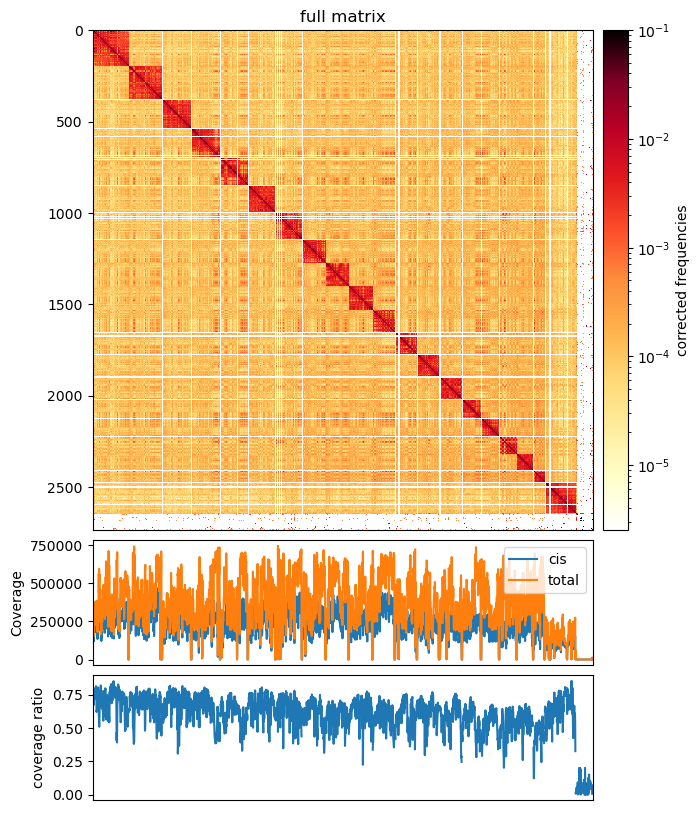

In [66]:
cis_coverage, tot_coverage = cooltools.coverage(clr)

f, ax = plt.subplots(
    figsize=(15, 10),
)

norm = LogNorm(vmax=0.1)

im = ax.matshow(
    clr.matrix()[:],
    norm=norm,
    cmap='fall'
);
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label='corrected frequencies');
ax.set_title('full matrix')
ax.xaxis.set_visible(False)

ax1 = divider.append_axes("bottom", size="25%", pad=0.1, sharex=ax)
weights = clr.bins()[:]['weight'].values
ax1.plot( cis_coverage, label='cis')
ax1.plot( tot_coverage, label='total')
ax1.set_xlim([0, len(clr.bins()[:])])
ax1.set_ylabel('Coverage')
ax1.legend()
ax1.set_xticks([])

ax2 = divider.append_axes("bottom", size="25%", pad=0.1, sharex=ax)
ax2.plot( cis_coverage/ tot_coverage)
ax2.set_xlim([0, len(clr.bins()[:])])
ax2.set_ylabel('coverage ratio')

zoom into some defined region

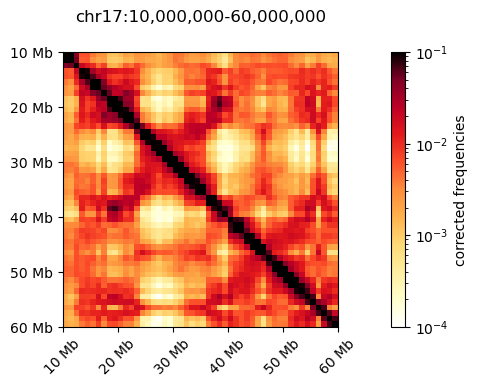

In [25]:
from matplotlib.ticker import EngFormatter
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cooltools
import cooler


bp_formatter = EngFormatter('b')


def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)
f, ax = plt.subplots(
    figsize=(14,4),
    ncols=1)


start, end = 10_000_000, 60_000_000
norm = LogNorm(vmax=0.1)

region = ('chr17', start, end)
im = ax.matshow(
    clr.matrix(balance=True).fetch(region),
    extent=(start, end, end, start),
    cmap='fall',
    norm=norm
);
ax.set_title(f'chr17:{start:,}-{end:,}', y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='corrected frequencies');
format_ticks(ax)
plt.tight_layout()


### Display contact maps around loci of interest (according to bed files)

preprocess bed files: bin adjacent features together

In [36]:
import pandas as pd
import glob
import os
from tqdm import tqdm

def merge_adjacent_features(bed_path, max_gap=10000):
    """
    Merge adjacent features in a BED file that are within max_gap distance
    """
    # Read BED file into DataFrame
    df = pd.read_csv(bed_path, sep='\t', header=None, 
                     names=['chrom', 'start', 'end'])
    
    # Sort by chromosome and start position
    df = df.sort_values(['chrom', 'start'])
    
    merged_features = []
    current_feature = None
    
    print(f"Merging adjacent features in {os.path.basename(bed_path)}...")
    for _, row in tqdm(df.iterrows(), total=len(df)):
        if current_feature is None:
            current_feature = row.copy()
            continue
            
        # Check if features are adjacent (within max_gap)
        if (row['chrom'] == current_feature['chrom'] and 
            row['start'] - current_feature['end'] <= max_gap):
            # Merge by updating end position
            current_feature['end'] = row['end']
        else:
            # Save current feature and start new one
            merged_features.append(current_feature)
            current_feature = row.copy()
    
    # Add final feature
    if current_feature is not None:
        merged_features.append(current_feature)
        
    # Convert to DataFrame
    merged_df = pd.DataFrame(merged_features)
    
    # Save merged features
    output_path = bed_path.replace('.bed', '_merged.bed')
    merged_df.to_csv(output_path, sep='\t', header=False, index=False)
    print(f"Saved merged features to: {output_path}")
    print(f"Reduced from {len(df)} to {len(merged_features)} features")
    
    return merged_df

# Get all bed files in the experimental_data directory
bed_dir = "/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/experimental_data/"
bed_files = glob.glob(os.path.join(bed_dir, "*.bed"))

print(f"Found {len(bed_files)} BED files to process")

# Process each bed file
for bed_path in bed_files:
    if not bed_path.endswith('_merged.bed'):  # Skip already merged files
        merged_features = merge_adjacent_features(bed_path)



Found 3 BED files to process
Merging adjacent features in Nuclear_speckle_anchors.bed...


100%|██████████| 835/835 [00:00<00:00, 43469.42it/s]


Saved merged features to: /Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/experimental_data/Nuclear_speckle_anchors_merged.bed
Reduced from 835 to 15 features
Merging adjacent features in gene-dense_anchors.bed...


100%|██████████| 261/261 [00:00<00:00, 44885.54it/s]


Saved merged features to: /Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/experimental_data/gene-dense_anchors_merged.bed
Reduced from 261 to 66 features
Merging adjacent features in enh-dense_anchors.bed...


100%|██████████| 439/439 [00:00<00:00, 49943.03it/s]

Saved merged features to: /Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/experimental_data/enh-dense_anchors_merged.bed
Reduced from 439 to 72 features


Call specific feature to zoom into from .bed file

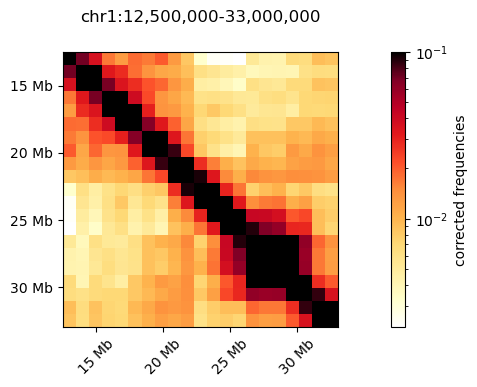

In [43]:
clr = cooler.Cooler(f'{ME_mcool}::resolutions/1000000')
bed_path = "/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/experimental_data/enh-dense_anchors_merged.bed"
feature_index = 0

with open(bed_path) as f:
    bed_lines = [line.strip().split() for line in f if line.strip()]
chrom, start, end = bed_lines[feature_index]
start, end = int(start), int(end)

#pad start and end by 10_000_000
start = start - 10000000
end = end + 10000000

f, ax = plt.subplots(
    figsize=(14,4),
    ncols=1)

norm = LogNorm(vmax=0.1)

region = (chrom, start, end)
im = ax.matshow(
    clr.matrix(balance=True).fetch(region),
    extent=(start, end, end, start),
    cmap='fall',
    norm=norm
);
ax.set_title(f'{chrom}:{start:,}-{end:,}', y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='corrected frequencies');
format_ticks(ax)
plt.tight_layout()

label contact map with bed annotations

In [94]:
import numpy as np
import pandas as pd

def load_bed_annotations(bed_files):
    """
    Load multiple BED files and return a dictionary with annotations
    
    Parameters:
    bed_files: dict with format {'label': 'path_to_bed_file'}
    
    Returns:
    dict with format {'label': pandas.DataFrame}
    """
    annotations = {}
    
    for label, bed_path in bed_files.items():
        # Read BED file
        bed_df = pd.read_csv(bed_path, sep='\t', header=None, 
                           names=['chrom', 'start', 'end'])
        annotations[label] = bed_df
        print(f"Loaded {len(bed_df)} features from {label}")
    
    return annotations

def add_bed_annotations_to_plot(ax, annotations, region=None, clr=None, 
                                symbols=None, colors=None, linewidth=2, alpha=0.8):
    """
    Add BED file annotations to a contact map plot
    
    Parameters:
    ax: matplotlib axis object
    annotations: dict of DataFrames from load_bed_annotations()
    region: tuple (chrom, start, end) for the plotted region, or None for whole genome
    clr: cooler object (needed for whole genome plots to get chromosome boundaries)
    symbols: dict mapping annotation labels to matplotlib symbols (default: different symbols)
    colors: dict mapping annotation labels to colors (default: different colors)
    linewidth: width of annotation lines
    alpha: transparency of annotation marks
    """
    
    if symbols is None:
        # Default symbols for different annotations
        symbol_list = ['s', '^', 'o', 'v', 'D', 'P', 'X', '*']
        symbols = {label: symbol_list[i % len(symbol_list)] 
                  for i, label in enumerate(annotations.keys())}
    
    if colors is None:
        # Default colors for different annotations
        color_list = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
        colors = {label: color_list[i % len(color_list)] 
                 for i, label in enumerate(annotations.keys())}
    
    # Get the current axis limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    for label, bed_df in annotations.items():
        if region is not None:
            # For regional plots, filter annotations to the specific region
            chrom, start, end = region
            
            # Filter for current chromosome and overlapping regions
            region_annotations = bed_df[
                (bed_df['chrom'] == chrom) & 
                (bed_df['end'] >= start) & 
                (bed_df['start'] <= end)
            ].copy()
            
            if len(region_annotations) > 0:
                # Convert genomic coordinates to plot coordinates (same as genomic for regional plots)
                x_positions = region_annotations[['start', 'end']].values
                y_positions = region_annotations[['start', 'end']].values
                
                # Add marks on x-axis (below)
                for _, row in region_annotations.iterrows():
                    mid_pos = (row['start'] + row['end']) / 2
                    ax.scatter([mid_pos], [ylim[1] + (ylim[1]-ylim[0])*0.01], marker=symbols[label], 
                             c=colors[label], s=50, alpha=alpha, 
                             label=f'{label}' if _ == region_annotations.index[0] else "")
                
                # Add marks on y-axis (left)
                for _, row in region_annotations.iterrows():
                    mid_pos = (row['start'] + row['end']) / 2
                    ax.scatter([xlim[0] - (xlim[1]-xlim[0])*0.01], [mid_pos], marker=symbols[label], 
                             c=colors[label], s=50, alpha=alpha)
                
                print(f"Added {len(region_annotations)} {label} annotations to region {chrom}:{start:,}-{end:,}")
        
        else:
            # For whole genome plots, convert genomic coordinates to bin coordinates
            if clr is None:
                raise ValueError("cooler object (clr) is required for whole genome annotations")
            
            for _, row in bed_df.iterrows():
                try:
                    # Convert genomic coordinates to bin coordinates
                    chrom = row['chrom']
                    start_bin = clr.extent(chrom)[0] + (row['start'] // clr.binsize)
                    end_bin = clr.extent(chrom)[0] + (row['end'] // clr.binsize)
                    mid_bin = (start_bin + end_bin) / 2
                    
                    # Check if the bin is within the current plot limits
                    if xlim[0] <= mid_bin <= xlim[1]:
                        # Add marks on x-axis (below)
                        ax.scatter([mid_bin], [ylim[1] + (ylim[1]-ylim[0])*0.01], marker=symbols[label], 
                                 c=colors[label], s=30, alpha=alpha)
                        
                        # Add marks on y-axis (left)  
                        ax.scatter([xlim[0] - (xlim[1]-xlim[0])*0.01], [mid_bin], marker=symbols[label], 
                                 c=colors[label], s=30, alpha=alpha)
                
                except Exception:
                    # Skip if chromosome not found in cooler
                    continue
            
            print(f"Added {label} annotations to whole genome plot")
    
    # Create legend
    legend_elements = [plt.Line2D([0], [0], marker=symbols[label], color='w', 
                                 markerfacecolor=colors[label], markersize=8, 
                                 label=label) for label in annotations.keys()]
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.15, 0.5))

# Define the BED files
bed_files = {
    'Enhancer-dense': '/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/experimental_data/enh-dense_anchors_merged.bed',
    'Gene-dense': '/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/experimental_data/gene-dense_anchors_merged.bed',
    'Nuclear speckle': '/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/experimental_data/Nuclear_speckle_anchors_merged.bed'
}

# Load all annotations
annotations = load_bed_annotations(bed_files)


Loaded 72 features from Enhancer-dense
Loaded 66 features from Gene-dense
Loaded 15 features from Nuclear speckle


In [45]:
# Print first 5 rows of each BED file
for label, bed_file in bed_files.items():
    print(f"\nFirst 5 rows of {label} BED file:")
    df = pd.read_csv(bed_file, sep='\t', header=None, 
                     names=['chrom', 'start', 'end'])
    print(df.head())




First 5 rows of Enhancer-dense BED file:
  chrom      start        end
0  chr1   22500000   23000000
1  chr1   33700000   34400000
2  chr1   59200000   59700000
3  chr1   63800000   64300000
4  chr1  154600000  155400000

First 5 rows of Gene-dense BED file:
   chrom      start        end
0  chr10    3300000    3500000
1  chr10    3900000    4500000
2  chr10  128700000  129000000
3  chr11    3200000    3800000
4  chr12    3200000    3800000

First 5 rows of Nuclear speckle BED file:
   chrom      start        end
0  chr11   95200000   99100000
1  chr11  100200000  103100000
2  chr11  115200000  121100000
3  chr13   54900000   57800000
4  chr15   76200000   79100000


Added Enhancer-dense annotations to whole genome plot
Added Gene-dense annotations to whole genome plot
Added Nuclear speckle annotations to whole genome plot


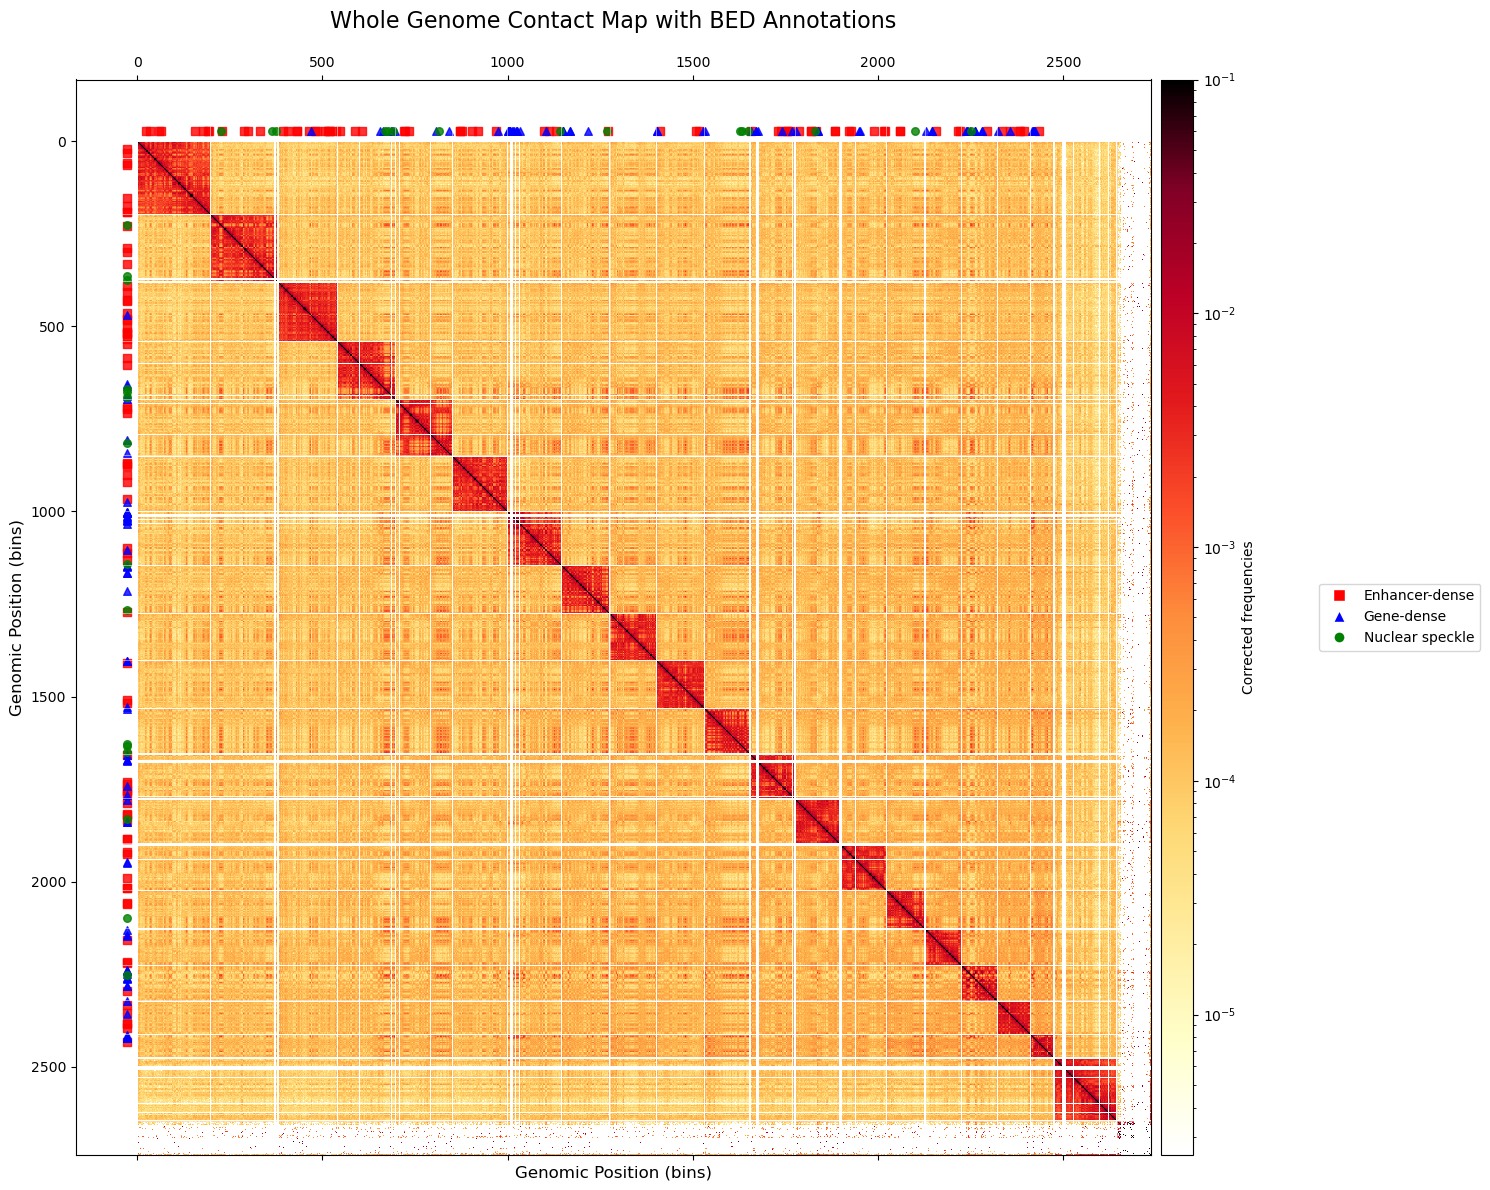

In [95]:
# Create whole genome contact map with annotations
clr = cooler.Cooler(f'{ME_mcool}::resolutions/1000000')
f, ax = plt.subplots(figsize=(16, 12))

norm = LogNorm(vmax=0.1)

# Plot the contact matrix
im = ax.matshow(
    clr.matrix()[:],
    norm=norm,
    cmap='fall'
)

# Set title and labels
ax.set_title('Whole Genome Contact Map with BED Annotations', fontsize=16, pad=20)
ax.set_xlabel('Genomic Position (bins)', fontsize=12)
ax.set_ylabel('Genomic Position (bins)', fontsize=12)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
plt.colorbar(im, cax=cax, label='Corrected frequencies')

# Add BED annotations
add_bed_annotations_to_plot(ax, annotations, region=None, clr=clr)

# Add chromosome boundaries (optional)
chromstarts = []
for chrom in clr.chromnames:
    chromstarts.append(clr.extent(chrom)[0])

# Add vertical and horizontal lines for chromosome boundaries
for start in chromstarts[1:]:  # Skip first chromosome start (0)
    ax.axvline(start, color='white', linewidth=0.5, alpha=0.7)
    ax.axhline(start, color='white', linewidth=0.5, alpha=0.7)

plt.tight_layout()


Added 1 Enhancer-dense annotations to region chr1:12,500,000-33,000,000


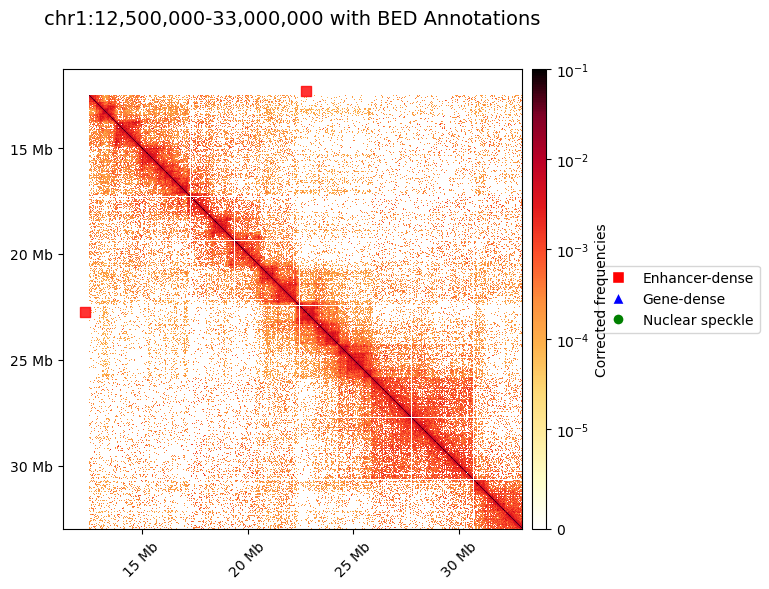

In [98]:
# Load higher resolution cooler for better regional detail
from matplotlib.colors import SymLogNorm

#note that balancing failed for 100kb resolution, feel to change the resolution as you like
clr_hires = cooler.Cooler(f'{ME_mcool}::resolutions/10000')  # 10kb resolution

# Use the same region as the previous example but with annotations
bed_path = "/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/experimental_data/enh-dense_anchors_merged.bed"
feature_index = 0

with open(bed_path) as f:
    bed_lines = [line.strip().split() for line in f if line.strip()]
chrom, start, end = bed_lines[feature_index]
start, end = int(start), int(end)

# Pad start and end by 10_000_000 - can change this to reflect intrachromosomal contacts around features of interest
start = start - 10000000
end = end + 10000000

f, ax = plt.subplots(figsize=(14, 6))

norm = SymLogNorm(linthresh=1e-5,   # half-width of the linear region
                  linscale=1.0,     # apparent size of that band on the colour-bar
                  vmin=0,           # lower end of the whole scale
                  vmax=0.1,         # upper end
                  base=10)  

region = (chrom, start, end)
im = ax.matshow(
    clr_hires.matrix(balance=True).fetch(region),
    extent=(start, end, end, start),
    cmap='fall',
    norm=norm
)

ax.set_title(f'{chrom}:{start:,}-{end:,} with BED Annotations', fontsize=14, y=1.08)

# Create divider for better colorbar placement
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
plt.colorbar(im, cax=cax, label='Corrected frequencies')

# Add BED annotations to the regional plot
add_bed_annotations_to_plot(ax, annotations, region=region)

# Format ticks
format_ticks(ax)
plt.tight_layout()


### Pileup plots calling bed features

In [99]:
import bioframe

enh = bioframe.read_table("/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/experimental_data/enh-dense_anchors_merged.bed", schema="bed").query(f'chrom in {clr.chromnames}')
enh['mid'] = (enh.end+enh.start)//2
enh.head()

chrom      start        end  name  score  strand        mid
0  chr1   22500000   23000000   NaN    NaN     NaN   22750000
1  chr1   33700000   34400000   NaN    NaN     NaN   34050000
2  chr1   59200000   59700000   NaN    NaN     NaN   59450000
3  chr1   63800000   64300000   NaN    NaN     NaN   64050000
4  chr1  154600000  155400000   NaN    NaN     NaN  155000000

=== Corrected Pileup Analysis ===
Loaded 72 enhancer features
Resolution: 2,000 bp
Using 72 clustered sites
Using flank: 250,000 bp (125 bins each side)
Creating pileup...


/Users/kadendimarco/.local/share/mamba/envs/polychrom/lib/python3.10/site-packages/cooltools/api/snipping.py:938: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features_df["region_offset"] = features_df["region"].replace(region_offsets_dict)
/Users/kadendimarco/.local/share/mamba/envs/polychrom/lib/python3.10/site-packages/cooltools/api/snipping.py:368: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region1_coords[0]
/Users/kadendimarco/.local/share/mamba/envs/polychrom/lib/python3.10/site-packages/cooltools/api/snipping.py:371: FutureWarning: Series.__getitem__ treating key

✅ Stack created successfully!
Stack shape: (72, 251, 251)
Expected: (72 sites, 251 bins, 251 bins)
Stack statistics:
  Total elements: 4,536,072
  Finite elements: 4,254,784
  NaN elements: 281,288
  Positive elements: 3,052,122
  Data range: 0.00e+00 to 7.84e-02
  Mean: 1.46e-03
Aggregated matrix shape: (251, 251)
Matrix statistics:
  Range: 1.38e-04 to 1.74e-02
  Mean: 1.46e-03
  Center value: nan
  Corner mean: 1.70e-04
  Central enrichment: nanx


/var/folders/8x/ydyynnlj6qb3n3b3bs1wqlt40000gn/T/ipykernel_35653/2528394146.py:60: RuntimeWarning: Mean of empty slice
  mtx = np.nanmean(stack, axis=0)  # Average across sites
/var/folders/8x/ydyynnlj6qb3n3b3bs1wqlt40000gn/T/ipykernel_35653/2528394146.py:150: RuntimeWarning: Mean of empty slice
  avg_val = np.nanmean(mtx[mask])


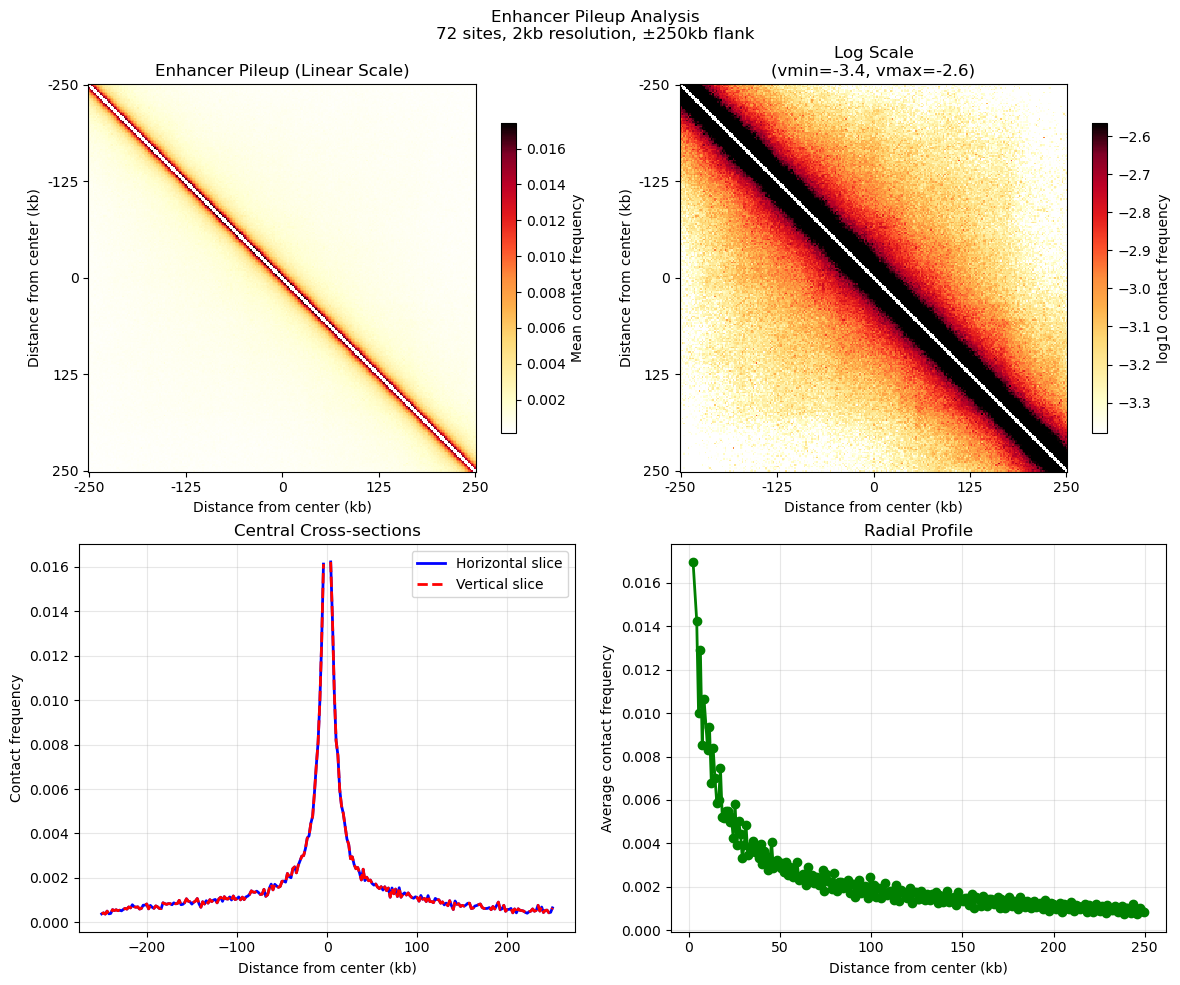


✅ Analysis complete!
Matrix size: 251×251 bins
Genomic window: ±250kb around enhancer centers


In [113]:
# Fixed pileup analysis with correct understanding of dimensions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

import cooler
import bioframe
import cooltools
import cooltools.lib.plotting

# Step 1: Load data 
ME_mcool = '/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/experimental_data/4DNFIZ39QE5I.mcool'
clr = cooler.Cooler(f'{ME_mcool}::resolutions/2000')
resolution = clr.binsize

enh = bioframe.read_table("/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/experimental_data/enh-dense_anchors_merged.bed", schema="bed").query(f'chrom in {clr.chromnames}')
enh['mid'] = (enh.end+enh.start)//2

print(f"=== Corrected Pileup Analysis ===")
print(f"Loaded {len(enh)} enhancer features")
print(f"Resolution: {resolution:,} bp")

# Step 2: Prepare sites
sites = enh.copy()
sites_clustered = bioframe.cluster(sites, min_dist=resolution).drop_duplicates('cluster').reset_index(drop=True)
print(f"Using {len(sites_clustered)} clustered sites")

# Step 3: Create proper view_df 
chromsizes_dict = dict(clr.chromsizes)
view_df = bioframe.make_viewframe(chromsizes_dict)

# Step 4: Use appropriate flank size - needs to be multiple of resolution for good results
flank = 250_000  
print(f"Using flank: {flank:,} bp ({flank//resolution} bins each side)")

try:
    # Create pileup
    print("Creating pileup...")
    stack = cooltools.pileup(clr, sites_clustered, view_df=view_df, flank=flank)
    print(f"✅ Stack created successfully!")
    print(f"Stack shape: {stack.shape}")  # Should be (n_sites, n_bins, n_bins)
    print(f"Expected: ({len(sites_clustered)} sites, {2*flank//resolution + 1} bins, {2*flank//resolution + 1} bins)")
    
    # Check stack statistics
    finite_mask = np.isfinite(stack)
    print(f"Stack statistics:")
    print(f"  Total elements: {stack.size:,}")
    print(f"  Finite elements: {np.sum(finite_mask):,}")
    print(f"  NaN elements: {np.sum(np.isnan(stack)):,}")
    print(f"  Positive elements: {np.sum(stack > 0):,}")
    
    if np.any(finite_mask):
        print(f"  Data range: {np.nanmin(stack):.2e} to {np.nanmax(stack):.2e}")
        print(f"  Mean: {np.nanmean(stack):.2e}")
    
    # Step 5: Aggregate correctly - average across sites (axis=0, not axis=2!)
    # stack shape is (n_sites, n_bins, n_bins), we want (n_bins, n_bins)
    mtx = np.nanmean(stack, axis=0)  # Average across sites
    print(f"Aggregated matrix shape: {mtx.shape}")
    
    # Check matrix statistics
    finite_mask_mtx = np.isfinite(mtx)
    if np.any(finite_mask_mtx):
        print(f"Matrix statistics:")
        print(f"  Range: {np.nanmin(mtx):.2e} to {np.nanmax(mtx):.2e}")
        print(f"  Mean: {np.nanmean(mtx):.2e}")
        
        # Check central enrichment
        center_idx = mtx.shape[0] // 2
        center_val = mtx[center_idx, center_idx]
        corner_vals = [mtx[0,0], mtx[0,-1], mtx[-1,0], mtx[-1,-1]]
        corner_mean = np.nanmean(corner_vals)
        print(f"  Center value: {center_val:.2e}")
        print(f"  Corner mean: {corner_mean:.2e}")
        if corner_mean > 0 and np.isfinite(corner_mean):
            print(f"  Central enrichment: {center_val/corner_mean:.2f}x")
    
    # Step 6: Create proper visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot 1: Linear scale
    if np.any(finite_mask_mtx):
        im1 = axes[0,0].imshow(mtx, cmap='fall', interpolation='none')
        axes[0,0].set_title('Enhancer Pileup (Linear Scale)')
        plt.colorbar(im1, ax=axes[0,0], shrink=0.8, label='Mean contact frequency')
    else:
        axes[0,0].text(0.5, 0.5, 'No finite data', ha='center', va='center', transform=axes[0,0].transAxes)
        axes[0,0].set_title('Linear Scale (No data)')
    
    # Plot 2: Log scale
    positive_mtx = np.where(mtx > 0, mtx, np.nan)
    if np.any(np.isfinite(positive_mtx)):
        finite_positive = positive_mtx[np.isfinite(positive_mtx)]
        if len(finite_positive) > 0:
            # Use percentiles for robust scaling
            vmin_log = np.log10(np.percentile(finite_positive, 10))
            vmax_log = np.log10(np.percentile(finite_positive, 90))
            
            im2 = axes[0,1].imshow(
                np.log10(positive_mtx),
                vmin=vmin_log,
                vmax=vmax_log,
                cmap='fall',
                interpolation='none'
            )
            axes[0,1].set_title(f'Log Scale\n(vmin={vmin_log:.1f}, vmax={vmax_log:.1f})')
            plt.colorbar(im2, ax=axes[0,1], shrink=0.8, label='log10 contact frequency')
        else:
            axes[0,1].text(0.5, 0.5, 'No positive values', ha='center', va='center', transform=axes[0,1].transAxes)
            axes[0,1].set_title('Log Scale (No positive values)')
    else:
        axes[0,1].text(0.5, 0.5, 'No positive values', ha='center', va='center', transform=axes[0,1].transAxes)
        axes[0,1].set_title('Log Scale (No positive values)')
    
    # Plot 3: Central cross-sections
    if mtx.shape[0] > 0:
        center_idx = mtx.shape[0] // 2
        center_row = mtx[center_idx, :]
        center_col = mtx[:, center_idx]
        
        # Convert bin indices to genomic coordinates
        n_bins = mtx.shape[0]
        bin_coords = np.arange(n_bins)
        genomic_coords = (bin_coords - n_bins//2) * resolution / 1000  # in kb
        
        axes[1,0].plot(genomic_coords, center_row, 'b-', linewidth=2, label='Horizontal slice')
        axes[1,0].plot(genomic_coords, center_col, 'r--', linewidth=2, label='Vertical slice')
        axes[1,0].set_title('Central Cross-sections')
        axes[1,0].set_xlabel('Distance from center (kb)')
        axes[1,0].set_ylabel('Contact frequency')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Radial average
    if mtx.shape[0] > 1:
        y, x = np.ogrid[:mtx.shape[0], :mtx.shape[1]]
        center = mtx.shape[0] // 2
        r = np.sqrt((x - center)**2 + (y - center)**2)
        
        max_radius = min(center, mtx.shape[0] - center - 1)
        r_bins = np.arange(0, max_radius + 0.5, 0.5)
        radial_profile = []
        radial_distances = []
        
        for i in range(len(r_bins)-1):
            mask = (r >= r_bins[i]) & (r < r_bins[i+1])
            if np.any(mask):
                avg_val = np.nanmean(mtx[mask])
                if np.isfinite(avg_val):
                    radial_profile.append(avg_val)
                    radial_distances.append((r_bins[i] + r_bins[i+1]) / 2 * resolution / 1000)  # in kb
        
        if len(radial_profile) > 0:
            axes[1,1].plot(radial_distances, radial_profile, 'go-', linewidth=2, markersize=6)
            axes[1,1].set_title('Radial Profile')
            axes[1,1].set_xlabel('Distance from center (kb)')
            axes[1,1].set_ylabel('Average contact frequency')
            axes[1,1].grid(True, alpha=0.3)
        else:
            axes[1,1].text(0.5, 0.5, 'No radial data', ha='center', va='center', transform=axes[1,1].transAxes)
    
    # Add proper tick labels to matrix plots
    n_bins = mtx.shape[0]
    tick_positions = np.linspace(0, n_bins-1, 5)
    tick_labels = [f"{int((pos - n_bins//2) * resolution / 1000)}" for pos in tick_positions]
    
    for ax in [axes[0,0], axes[0,1]]:
        if ax.get_images():
            ax.set_xticks(tick_positions)
            ax.set_xticklabels(tick_labels)
            ax.set_yticks(tick_positions)
            ax.set_yticklabels(tick_labels)
            ax.set_xlabel('Distance from center (kb)')
            ax.set_ylabel('Distance from center (kb)')
    
    plt.suptitle(f'Enhancer Pileup Analysis\n{len(sites_clustered)} sites, {resolution//1000}kb resolution, ±{flank//1000}kb flank')
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Analysis complete!")
    print(f"Matrix size: {mtx.shape[0]}×{mtx.shape[1]} bins")
    print(f"Genomic window: ±{flank//1000}kb around enhancer centers")
    
except Exception as e:
    print(f"❌ Analysis failed: {e}")
    import traceback
    traceback.print_exc()

In [131]:
# Use existing data
ME_mcool = '/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/experimental_data/4DNFIZ39QE5I.mcool'
clr = cooler.Cooler(f'{ME_mcool}::resolutions/10000')
resolution = clr.binsize

enh = bioframe.read_table("/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/Megaenhancers/experimental_data/enh-dense_anchors_merged.bed", schema="bed").query(f'chrom in {clr.chromnames}')
enh['mid'] = (enh.end+enh.start)//2

sites = bioframe.cluster(enh, min_dist=resolution).drop_duplicates('cluster').reset_index(drop=True)

#mouse chromosomes are telocentric, so whole chromosome behaves like a single arm

chromsizes_dict = dict(clr.chromsizes)
view_df = bioframe.make_viewframe(chromsizes_dict)
sites.head()


chrom      start        end  name  score  strand        mid  cluster  \
0  chr1   22500000   23000000   NaN    NaN     NaN   22750000        0   
1  chr1   33700000   34400000   NaN    NaN     NaN   34050000        1   
2  chr1   59200000   59700000   NaN    NaN     NaN   59450000        2   
3  chr1   63800000   64300000   NaN    NaN     NaN   64050000        3   
4  chr1  154600000  155400000   NaN    NaN     NaN  155000000        4   

   cluster_start  cluster_end  
0       22500000     23000000  
1       33700000     34400000  
2       59200000     59700000  
3       63800000     64300000  
4      154600000    155400000

Loading .clpy file with h5py...
File keys: ['annotation', 'attrs', 'data']
annotation: Group
annotation/axis0: Dataset
  Shape: (39,)
  Dtype: |S20
annotation/axis1: Dataset
  Shape: (1,)
  Dtype: int64
annotation/block0_items: Dataset
  Shape: (12,)
  Dtype: |S20
annotation/block0_values: Dataset
  Shape: (1, 12)
  Dtype: uint8
annotation/block1_items: Dataset
  Shape: (1,)
  Dtype: |S7
annotation/block1_values: Dataset
  Shape: (1, 1)
  Dtype: float64
annotation/block2_items: Dataset
  Shape: (1,)
  Dtype: |S10
annotation/block2_values: Dataset
  Shape: (1, 1)
  Dtype: int32
annotation/block3_items: Dataset
  Shape: (10,)
  Dtype: |S12
annotation/block3_values: Dataset
  Shape: (1, 10)
  Dtype: int64
annotation/block4_items: Dataset
  Shape: (15,)
  Dtype: |S18
annotation/block4_values: Dataset
  Shape: (1,)
  Dtype: object
attrs: Group
data: Dataset
  Shape: (301, 301)
  Dtype: float32
Loaded pileup shape: (301, 301)


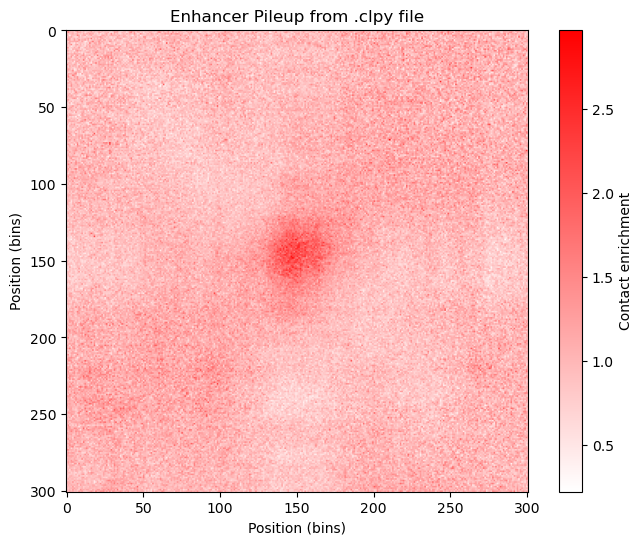

Final pileup shape: (301, 301)
Data range: 0.219 to 2.975


In [142]:
# Alternative approach using h5py (since .clpy files are HDF5-based)
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)

clpy_file = './experimental_data/4DNFIZ39QE5I.mcool-10.0K_over_enh-dense_anchors_merged_10-shifts.clpy'

print("Loading .clpy file with h5py...")

with h5py.File(clpy_file, 'r') as f:
    print(f"File keys: {list(f.keys())}")
    
    # Explore the structure
    def print_structure(name, obj):
        print(f"{name}: {type(obj).__name__}")
        if hasattr(obj, 'shape'):
            print(f"  Shape: {obj.shape}")
        if hasattr(obj, 'dtype'):
            print(f"  Dtype: {obj.dtype}")
    
    f.visititems(print_structure)
    
    # Load the pileup data (common locations)
    if 'pileup' in f:
        pileup = f['pileup'][:]
    elif 'data' in f:
        pileup = f['data'][:]
    elif 'stack' in f:
        pileup = f['stack'][:]
    else:
        # Get the first dataset
        for key in f.keys():
            if isinstance(f[key], h5py.Dataset):
                pileup = f[key][:]
                print(f"Using dataset '{key}'")
                break

print(f"Loaded pileup shape: {pileup.shape}")

# If it's 3D, take the mean or a specific slice
if pileup.ndim == 3:
    print("3D data detected - taking mean across first dimension")
    pileup = np.nanmean(pileup, axis=0)

# Plot
plt.figure(figsize=(8, 6))
#plt.imshow(pileup, cmap='fall', interpolation='none')
plt.imshow(pileup, cmap=fruitpunch)
plt.colorbar(label='Contact enrichment')
plt.title('Enhancer Pileup from .clpy file')
plt.xlabel('Position (bins)')
plt.ylabel('Position (bins)')
plt.show()

print(f"Final pileup shape: {pileup.shape}")
print(f"Data range: {np.nanmin(pileup):.3f} to {np.nanmax(pileup):.3f}")

## try using coolpup again

Generate chromosome-wide expected values

plotpup.py \
    --cmap Reds \
    --scale log \
    --vmin 0.5 --vmax 3 \
    --dpi 300 \
    --norm_corners 5 \
    --ignore_central 1 \
    --input_pups mega_enhancer_25kb_coolpup_pileup.clpy \
    -o mega_enhancer_pileup.png

### try juicer using Yue's loops
